# **Discovering Stop-Antistop Quark Pair Production ($\tilde{t},\tilde{\bar{t}}$) with ATLAS Open Data**
This notebook will guide you through a hands-on analysis of high-energy proton-proton collision data from the ATLAS experiment at the Large Hadron Collider (LHC), focusing on the search for supersymmetric top quark partners: the **stop ($\tilde{t}$)** and **antistop ($\tilde{\bar{t}}$)**. These hypothetical particles are predicted by Supersymmetry (SUSY) and could provide answers to fundamental open questions in the Standard Model.

ATLAS Open Data offers publicly available datasets collected at $\sqrt{s} = 13$ TeV, ideal for educational analyses ranging from high-school to postgraduate levels. In this notebook, you will learn how to:

Understand the event topology of stop-antistop production.

Apply event selection ("cuts") to enhance the sensitivity to SUSY signals.

Use physics-motivated observables (e.g., lepton kinematics, b-tagged jets, missing transverse energy) to reduce backgrounds.

Reconstruct variables relevant to SUSY signatures and search for excesses beyond the Standard Model expectations.

# **Physics Motivation: The $\tilde{t},\tilde{\bar{t}}$ Decay Channel**
We focus on the decay chain:

$\tilde{t}\tilde{\bar{t}} → t\bar{t} + \tilde{χ}^0_1\tilde{χ}^0_1 → (bW^+)(\bar{b}W^-) + \tilde{χ}^0_1\tilde{χ}^0_1$

Assuming both $W$ bosons decay leptonically, and considering one electron and one muon in the final state, we study the following signature:

$pp → \tilde{t}\tilde{\bar{t}} → e^{±}μ^{∓}b\bar{b} + E^{miss}_T$

where:

$e^\pm$, $\mu^\mp$ are opposite-sign, different-flavor leptons,

$b$, $\bar{b}$ are b-tagged jets,

$E_T^{\text{miss}}$ represents the missing transverse energy due to undetected neutralinos ($\tilde{\chi}_1^0$).

This dileptonic channel has a relatively low Standard Model background and good sensitivity to SUSY signals.

# **The Goal: Identify a SUSY Signal in the $e\mu b\bar{b} + E_T^{\text{miss}}$ Final State**
By following this notebook, you will aim to identify an excess of events consistent with the decay of $\tilde{t},\tilde{\bar{t}}$ pairs. You will:

Select events with exactly one isolated electron and one isolated muon,

Require at least two b-tagged jets,

Study the distributions of $Δη(l^+l^-)$, $Δφ(l^+l^-)$and other variables,

Compare data with Standard Model Monte Carlo (MC) simulations to assess compatibility or deviations

# **What Are Notebooks?**

Notebooks are interactive web applications that allow you to create and share documents that contain:

1. **Live code:** Write and execute code in real-time, making adjustments as you go.

2. **Visualizations:** Create plots, histograms, and other graphical representations of your data to better understand the underlying physics.

3. **Narrative text:** Include explanations, descriptions, and commentary to guide yourself or others through the analysis.

# **Running a Jupyter notebook**
To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.


# **ATLAS Open Data Initialisation**
**First time package installation on your computer**

This first cell installs the required python packages. It only needs to be run the first time you open this notebook on your computer. If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

In [ ]:
!pip install atlasopenmagic
!pip install uproot

# **To setup**
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us use efficiently the nested data in columnar format
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* concurrent.futures: Enables parallel execution, which speeds up computations when working with large datasets.

In [ ]:
import uproot  # For reading ROOT files efficiently
import awkward as ak  # To represent nested data in columnar format
import numpy as np  # For numerical calculations such as histogramming
import pandas as pd # For dataframes, a format widely used in python
import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator  # For adding minor ticks to plot axes
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
from concurrent.futures import ProcessPoolExecutor, as_completed # Enables parallel execution for faster processing of large datasets

import time  # For timing operations and adding delays if needed
# Filter warnings that otherwise appear in output. These are normal in the running of this notebook.
import warnings

import matplotlib.animation as animation
from IPython.display import HTML

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Explanation of Key Parameters in the $\tilde{t}\tilde{\bar{t}}$ Analysis Code**

In particle physics analyses, various parameters and constants are essential for accurately processing data and interpreting results. Below is an explanation of the key parameters used in the
 $t\bar{t}$ analysis code provided:

1.   **Integrated Luminosity (lumi)**

  *   Definition: Integrated luminosity is a measure of the total amount of data collected by a particle detector over a certain period. It represents the total number of potential collisions that could have occurred in a particle accelerator and is typically measured in inverse femtobarns fb$^{-1}$.

2. **Fraction of Events to Process**

  *   Definition: This parameter controls what fraction of the available events in the dataset will be processed by the analysis.


3. **MV2c10 b-Tagging Algorithm Discriminant Cut Value Definition**
  * The MV2c10 is a b-tagging algorithm used to identify jets originating from b-quarks. The discriminant cut value determines the threshold for tagging a jet as a b-jet.

  For further information visit [atlas glossary](https://atlas.cern/glossary)

In [ ]:
# Integrated luminosity in inverse picobarns
lumi = 36000.

# Fraction of events to process
fraction = 0.01

# MV2c10 b-tagging algorithm discriminant cut value
MV2c10_lim = 4

# **Samples**
To study the production of stop-antistop quark pairs ($\tilde{t} \tilde{\bar{t}}$), we employ a carefully chosen set of data and Monte Carlo (MC) simulation samples. These samples capture both the potential signal from supersymmetric processes and the dominant background contributions from Standard Model (SM) processes that can mimic the expected final state.

In [ ]:
# Set the ATOM analysis release version to a specific beta version for 13 TeV data from 2025
atom.set_release('2025e-13tev-beta')

# Define the data samples using dataset identifiers (DIDs)
data_defs = {
    r'Data':  {'dids': ["data"]}
}

# Define the first set of Monte Carlo (MC) samples
mc_defs = {
    r'Data':  {'dids': ["data"]},
    r'ttbar': {'dids': [410470,410471]},
    r'tW': {'dids': [410658,410659,410644,410645,601352,601355]},
}

# Define a second set of MC samples for a different ttbar variant
mc_defs_1 = {
    r'ttbar_1': {'dids': [411234]}
}

# Define a third set of MC samples, repeating ttbar for the truth
mc_defs_2 = {
    r'ttbar': {'dids': [410470,410471]}
}

# Build the actual datasets using the ATOM API with a skim named '2J2LMET30'
data = atom.build_dataset(data_defs, skim='2J2LMET30', protocol='https')  # Build data sample
mc_samples_1 = atom.build_dataset(mc_defs, skim='2J2LMET30', protocol='https')  # Build first MC sample set
mc_samples_2 = atom.build_dataset(mc_defs_1, skim='2J2LMET30', protocol='https')  # Build second MC sample set
mc_samples_3 = atom.build_dataset(mc_defs_2, skim='2J2LMET30', protocol='https')  # Build third MC sample set

# Merge all datasets into a single dictionary for processing
samples = {**data, **mc_samples_1, **mc_samples_2, **mc_samples_3}

# Define the list of variables to be extracted from the datasets
variables = [
    "mcWeight", "ScaleFactor_LepTRIGGER", "ScaleFactor_MLTRIGGER", "trigE", "trigM", "lep_n", "lep_pt", "ScaleFactor_BTAG",
    "lep_eta", "lep_phi", "lep_charge", "lep_type", "met", "met_phi", "sum_of_weights", "ScaleFactor_FTAG",
    "xsec", "jet_pt", "jet_btag_quantile", "jet_n", "jet_eta", "jet_phi", "jet_e", "jet_jvt", "lep_isTrigMatched",
    "lep_type", "lep_e", "eventNumber", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_PILEUP", "filteff", "kfac",
    "truth_elec_n", "truth_elec_eta", "truth_elec_phi", "truth_elec_pt", "truth_muon_n", "truth_muon_eta", "truth_muon_phi", "truth_muon_pt",
    "truth_jet_pt", "truth_jet_eta", "truth_jet_phi"]

Active release set to: 2025e-13tev-beta. Metadata cache cleared.
Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


# **Weight in Supersymmetric Particle Physics Analysis**
In searches for new physics phenomena, such as the production of scalar top quark pairs ($\tilde{t} \tilde{\bar{t}}$) in supersymmetric (SUSY) models, event weights are essential to accurately interpret the results of Monte Carlo (MC) simulations and compare them with real experimental data.

Each MC event represents not a single physical occurrence, but rather a probabilistic sample of a certain physical process. To ensure that the total event yield and distributions correctly reflect the expected number of events in actual data, weights are applied to each event.

In [ ]:
def calc_weight(data):
    weight_list =( data["ScaleFactor_MLTRIGGER"] * data["ScaleFactor_PILEUP"] * data["ScaleFactor_LepTRIGGER"] *
                 ( data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) *
                 (data["xsec"] * data["filteff"] * data["kfac"] * lumi) )
    return weight_list

# **Introduction to Event Selection Cuts in $\tilde{t}\tilde{\bar{t}}$ Analysis**

In particle physics, particularly in the analysis of stop-antistop $\tilde{t}\tilde{\bar{t}}$ quark pair production, the process of event selection is crucial for isolating the signal from the background. The goal is to apply a series of cuts, or selection criteria, that filter out events unlikely to be associated with the $\tilde{t}\tilde{\bar{t}}$ process, leaving a dataset enriched with signal events. These cuts are based on specific physical properties of the events, such as the presence and characteristics of leptons and jets.

Each cut is designed to enhance the signal-to-background ratio, which is essential for making a clear observation of the $\tilde{t}\tilde{\bar{t}}$ signal. Below is an overview of the key cuts applied in this analysis:

1. **Trigger Selection:**
  * The first step in the analysis is to ensure that the events under consideration have fired the appropriate triggers.
  * Purpose: This cut checks whether both the electron trigger ('trigE') and the muon trigger ('trigM') has been activated. If both triggers fired, the event is considered for further analysis.

In [ ]:
def tr_cuts(trE, trM):
    # selecting events where exactly two lepton triggers
    return ak.sum((trE) | (trM) ,axis=1) == 2

2. **Lepton Multiplicity Selection:**
* This selection ensures that events contain exactly two leptons, which is a requirement for analyses targeting dilepton final states

In [ ]:
def num_lep(lep_n):
    # selecting events where exactly two leptons
    return lep_n == 2

3. **Jet Selection:**

The function applies two conditions:

* Jet $p_T$ and $\eta$ Requirement:

  *   At least two jets must have a transverse momentum $p_T \geq 25 GeV$ and pseudorapidity within
$|\eta| < 2.5$.

*   b-tagging Requirement:
  *   The event must contain at least one jet with a $b-tagging \geq 4$.

In [ ]:
def jets_cuts(jet_pt, eta, btag):
    # Select events with at least 2 jets having pT ≥ 25 GeV and |η| < 2.5
    num_pt = ak.sum((jet_pt >= 25) & (np.abs(eta) < 2.5), axis=1) >= 2

    # Select events with at least 1 jet having a b-tagging score ≥ 4
    num_btag = ak.sum(btag >= 4, axis=1) >= 1

    return num_pt & num_btag

4. **Delta R ($\Delta R$) Cut:**

This function ensures that the jets in the event are sufficiently separated from the leptons in the $\eta-\phi$ space, which helps to reduce contamination from misidentified events.

  * Purpose: The cut calculates the $\Delta R$ values for each jet with respect to both leptons using their pseudorapidities ($\eta$) and azimuthal angles ($\phi$):

    * Calculating $\Delta R$ for Each lepton:
      $\Delta R_{1}$ is computed between each jet and the first lepton.
      $\Delta R_{2}$ is computed between each jet and the second lepton.
    * Separation Criteria: The cut checks if at least one jet is separated from each lepton by $\Delta R \geq 0.4$.

In [ ]:
def cut_DR(eta, phi, eta_lep, phi_lep):

    # Compute Δφ between each jet and the first lepton
    Dphi1 = np.arccos(np.cos(phi - phi_lep[:, 0]))  # Use arccos(cos(Δφ)) to ensure Δφ ∈ [0, π]

    # Compute Δφ between each jet and the second lepton
    Dphi2 = np.arccos(np.cos(phi - phi_lep[:, 1]))

    # Compute Δη between each jet and the first lepton
    Deta1 = eta - eta_lep[:, 0]

    # Compute Δη between each jet and the second lepton
    Deta2 = eta - eta_lep[:, 1]

    # Compute ΔR between each jet and the first lepton: ΔR = sqrt((Δη)^2 + (Δφ)^2)
    DR_1 = np.sqrt(Deta1**2 + Dphi1**2)

    # Compute ΔR between each jet and the second lepton
    DR_2 = np.sqrt(Deta2**2 + Dphi2**2)

    # Check if for each event, there is at least one jet satisfying ΔR ≥ 0.4
    DR_1_check = ak.sum(DR_1 >= 0.4, axis=1) >= 1

    # Check if for each event, there is at least one jet satisfying ΔR ≥ 0.4
    DR_2_check = ak.sum(DR_2 >= 0.4, axis=1) >= 1

    # Return events where both leptons are separated from jets by ΔR ≥ 0.4 (at least one jet each)
    return (DR_1_check) & (DR_2_check)


5. **Lepton Type and Charge Selection:**

This function ensures that the selected events contain exactly one electron and one muon with opposite electric charges. The function applies two conditions:

* Lepton Type Requirement:

  * The sum of the lep_type values must equal 24. In the ATLAS convention, the lepton type is often encoded as:
  
  * 11: $e^-$ or  $e^+$

  * 13: $μ^-$ or  $μ^+$

  * Thus, 11+13=24, ensuring that one electron and one muon are present in the event.

* Lepton Charge Requirement:

  * The sum of the lepton charges must equal 0, the leptons must have opposite electric charges.

In [ ]:
def charge_and_type_cut(lep_type, lep_cha):
    # Select events where the sum of lepton types equals 24
    type_cut = ak.sum(lep_type, axis=1) == 24

    # Select events where the sum of lepton charges equals 0
    lep_change = ak.sum(lep_cha, axis=1) == 0

    return type_cut & lep_change

6. **Lepton Kinematic Selection:**

The function applies two conditions:

* Lepton Transverse Momentum ($p_T$) Requirement:

  * Each event must contain at least two leptons with transverse momentum:
    $p_T \geq 25 GeV$
  
    This threshold ensures that selected leptons are energetic enough to pass trigger thresholds and to be well-measured.

* Lepton Pseudorapidity ($\eta$) Requirement:

  * Each event must also contain at least two leptons within the pseudorapidity range:
    $|\eta| < 2.5$
  
    This condition restricts leptons to the central part of the detector, where reconstruction and identification are most reliable.

In [ ]:
def cut_lep_pt(lep_pt, eta):
    # Select events with at least 2 leptons having pT > 25 GeV
    pt_cut = ak.sum(lep_pt > 25, axis=1) >= 2

    # Select events with at least 2 leptons within the pseudorapidity range |η| < 2.5
    eta_cut = ak.sum(np.abs(eta) < 2.5, axis=1) >= 2

    return pt_cut & eta_cut

7. **Truth Jet Multiplicity Cut:**

This function applies a selection criterion on the number of truth-level jets with sufficient transverse momentum. Specifically:

* Jet  $p_{T}$ Threshold:

  * Only jets with transverse momentum greater than or equal to 25 GeV are considered.

In [ ]:
def tr_jets_cuts(jet_pt):
    # Select events with at least 2 truth jets having pT ≥ 25 GeV
    return ak.sum(jet_pt >= 25, axis=1) >= 2

8. **Truth Lepton Multiplicity Cut:**

This function applies a selection on the number of truth-level leptons in each event, ensuring that exactly one electron and one muon are present. The cut includes:

* **Count Requirement:**

  * The number of truth-level electrons and muons must be exactly one in each event.

In [ ]:
def tr_lep_num_cut(truth_e_pt,truth_m_pt):
    # Count number of truth electrons per event, select those with exactly one
    num_e = ak.count(truth_e_pt, axis=1) == 1

    # Count number of truth muons per event, select those with exactly one
    num_m = ak.count(truth_m_pt, axis=1) == 1

    return (num_e & num_m)

9. **Truth Lepton $p_{T}$ Cut:**

This function applies transverse momentum selection criteria on the truth-level leptons (electrons and muons) to ensure that both leptons in the event are energetic enough to pass analysis thresholds. The cut is defined as follows:

* **$p_{T}$ Requirement:**

  * The event must contain exactly one truth-level electron and muon with transverse momentum $p_{T} \ge 25 GeV$.


In [ ]:
def tr_lep_pt_cut(truth_e_pt,truth_m_pt):
    # Select events where exactly one truth electron has pT ≥ 25 GeV
    pt_e_cut = ak.sum(truth_e_pt >= 25, axis=1) == 1

    # Select events where exactly one truth muon has pT ≥ 25 GeV
    pt_m_cut = ak.sum(truth_m_pt >= 25, axis=1) == 1

    return (pt_e_cut & pt_m_cut)

10. **Truth Lepton-Jet Angular Separation ($\Delta R$) Cut:**

This function imposes an angular separation requirement between each truth-level lepton (electron and muon) and all truth-level jets in an event. Specifically, it ensures that leptons are sufficiently isolated from jets, a standard requirement in event selection to reduce contamination from jet activity.

* **Definition of Angular Separation:**

  The angular distance $\Delta R$ between a lepton and a jet is defined as:
  $\Delta R= \sqrt{ (\Delta\eta)^2 + (\Delta\phi)^2}$
  where:
  * $\Delta\eta$ is the difference in pseudorapidity between the lepton and the jet.
  * $\Delta\phi$ is the difference in azimuthal angle, computed using a cosine-based definition to account for $2\pi$ periodicity.

In [ ]:
def tr_lep_DR_cut(e_e, e_p, m_e, m_p, j_e, j_p):
    # Compute Δφ between each jet and all truth electrons
    Dphi1 = np.arccos(np.cos(j_p - ak.flatten(e_p, axis=1)))

    # Compute Δφ between each jet and all truth muons
    Dphi2 = np.arccos(np.cos(j_p - ak.flatten(m_p, axis=1)))

    # Compute Δη between each jet and all truth electrons
    Deta1 = j_e - ak.flatten(e_e, axis=1)  # Use flattened η of truth electrons

    # Compute Δη between each jet and all truth muons
    Deta2 = j_e - ak.flatten(m_e, axis=1)  # Use flattened η of truth muons

    # Compute ΔR between each jet and each truth electron
    DR_1 = np.sqrt(Deta1**2 + Dphi1**2)

    # Compute ΔR between each jet and each truth muon
    DR_2 = np.sqrt(Deta2**2 + Dphi2**2)

    # Check if at least one truth electron is separated from a jet by ΔR ≥ 0.4
    DR_1_check = ak.sum(DR_1 >= 0.4, axis=1) >= 1

    # Check if at least one truth muon is separated from a jet by ΔR ≥ 0.4
    DR_2_check = ak.sum(DR_2 >= 0.4, axis=1) >= 1

    # Return events that pass both electron-jet and muon-jet ΔR separation criteria
    return (DR_1_check) & (DR_2_check)


# **Angular Separation Calculation**
**Angular Separation Calculation:** This function computes the angular separation between two leptons in each event in terms of their azimuthal angle difference ($\Delta\phi$) and pseudorapidity difference ($\Delta\eta$). These quantities are essential for constructing kinematic observables such as the invariant mass and $\Delta R$, and they also provide insight into the event topology.

  The function returns:

* $\Delta\phi$:
  The difference in azimuthal angle (in radians) between the two leptons, defined as: $\Delta\phi = |arccos(cos(\phi_1-\phi_2))|$
  This formulation ensures that $\Delta\phi \in [0,\pi]$.

* $\Delta\eta$: The absolute difference in pseudorapidity between the two leptons:$\Delta\eta = |\eta_1 - \eta_2|$

In [ ]:
def calc_dphi_and_deta(lep_eta,lep_phi):
    # Calculate the absolute Δφ between the two leptons,
    # using arccos(cos(Δφ)) to ensure the result lies in [0, π]
    dphi = np.abs(np.arccos(np.cos(lep_phi[:, 0] - lep_phi[:, 1])))

    # Calculate the absolute Δη between the two leptons
    deta = np.abs(lep_eta[:, 0] - lep_eta[:, 1])
    return [dphi,deta]

**Truth Lepton Angular Separation:**

This function computes the angular distance between the selected truth-level electron and muon in each event.

In [ ]:
def calc_tr_dphi_and_deta(tr_elec_eta,tr_elec_phi,tr_muon_eta,tr_muon_phi):
    # Calculate the absolute difference in pseudorapidity (Δη) between truth electrons and muons
    deta = np.abs(tr_elec_eta - tr_muon_eta)

    # Calculate the absolute difference in azimuthal angle (Δφ) using arccos(cos(Δφ)) to ensure angle is in [0, π]
    dphi = np.abs(np.arccos(np.cos(tr_elec_phi - tr_muon_phi)))

    # Flatten awkward arrays into 1D arrays
    deta = ak.flatten(deta, axis=None)
    dphi = ak.flatten(dphi, axis=None)

    return [dphi,deta]

**Lepton Matching and Final-State Angular Separation:**

This function identifies the best-matched reconstructed leptons corresponding to the truth-level electron and muon in each event. The matching is based on the angular separation ($\Delta R$) between truth and reconstructed particles. Once the best matches are found, the function computes the angular separation between the matched electron and muon in terms of ($\Delta\phi$) and ($\Delta\eta$).

* **Matching Strategy:**

  * For each truth-level electron and muon, the function computes the ($\Delta R$) distance to **all** reconstructed leptons of the same flavor:$\Delta R= \sqrt{ (\eta_\text{truth} - \eta_\text{reco})^2
   + (\phi_\text{truth} - \phi_\text{reco})^2 }$

* **Robustness Handling:**

  * Events with no matching reconstructed leptons are assigned large pseudorapidity values (e.g., \( 10^4 \)) to signal invalid pairings.
  * This avoids propagation of empty structures and makes downstream selection steps more stable.

* **Output:**

  * The function returns two arrays: ($\Delta\phi$) and ($\Delta\eta$), corresponding to the best-matched reconstructed leptons.


In [ ]:
def calc_truth_dphi_and_deta(tr_elec_eta, tr_elec_phi, tr_elec_pt,
                             tr_muon_eta, tr_muon_phi, tr_muon_pt,
                             re_eta, re_phi, lep_type):

    # Broadcast flattened reconstructed electron η where lepton type == 11 (electron) with truth electron η
    bee = ak.broadcast_arrays(ak.flatten(re_eta[lep_type == 11]), tr_elec_eta)

    # Broadcast flattened reconstructed muon η where lepton type == 13 (muon) with truth muon η
    bem = ak.broadcast_arrays(ak.flatten(re_eta[lep_type == 13]), tr_muon_eta)

    # Broadcast flattened reconstructed electron φ with truth electron φ
    bpe = ak.broadcast_arrays(ak.flatten(re_phi[lep_type == 11]), tr_elec_phi)

    # Broadcast flattened reconstructed muon φ with truth muon φ
    bpm = ak.broadcast_arrays(ak.flatten(re_phi[lep_type == 13]), tr_muon_phi)

    # Compute ΔR between reconstructed electrons and truth electrons
    DRe = np.sqrt((bee[0] - tr_elec_eta)**2 + (bpe[0] - tr_elec_phi)**2)

    # Compute ΔR between reconstructed muons and truth muons
    DRm = np.sqrt((bem[0] - tr_muon_eta)**2 + (bpm[0] - tr_muon_phi)**2)

    # For each event, find index of reconstructed electron closest to truth electron (minimal ΔR)
    keeper_elec = ak.singletons(ak.argmin(DRe, axis=1))

    # For each event, find index of reconstructed muon closest to truth muon (minimal ΔR)
    keeper_muon = ak.singletons(ak.argmin(DRm, axis=1))

    # Select the matched truth electron η, φ, and pT using the indices of closest reconstructed electron
    keeper_e_e = tr_elec_eta[keeper_elec]
    keeper_e_p = tr_elec_phi[keeper_elec]
    keeper_e_pt = tr_elec_pt[keeper_elec]

    # Select the matched truth muon η, φ, and pT using the indices of closest reconstructed muon
    keeper_m_e = tr_muon_eta[keeper_muon]
    keeper_m_p = tr_muon_phi[keeper_muon]
    keeper_m_pt = tr_muon_pt[keeper_muon]

    # Handle cases where no matched truth electron exists by replacing with large dummy values
    check_keeper_e_e = ak.where(ak.num(keeper_e_e) == 0, [1e5], keeper_e_e)
    check_keeper_e_p = ak.where(ak.num(keeper_e_p) == 0, [1e5], keeper_e_p)

    # Handle cases where no matched truth muon exists by replacing with large dummy values
    check_keeper_m_e = ak.where(ak.num(keeper_m_e) == 0, [1e5], keeper_m_e)
    check_keeper_m_p = ak.where(ak.num(keeper_m_p) == 0, [1e5], keeper_m_p)

    # Calculate absolute Δη between matched truth electrons and muons
    deta = np.abs(check_keeper_e_e - check_keeper_m_e)

    # Calculate absolute Δφ between matched truth electrons and muons, using arccos(cos(Δφ)) for proper angle range
    dphi = np.abs(np.arccos(np.cos(check_keeper_e_p - check_keeper_m_p)))

    # Flatten awkward arrays for output consistency
    deta = ak.flatten(deta, axis=None)
    dphi = ak.flatten(dphi, axis=None)

    return [dphi, deta]

# **Event Processing Function**

The process_file function processes ROOT files by:

1. **Loading data**: Opens the TTree and reads specified variables in chunks
2. **Applying selection cuts**: Implements a sequential series of cuts
3. **Computing derived quantities**: Calculates invariant mass and event weights

The function processes data in chunks to manage memory efficiently and returns a flattened array of all events that pass the selection criteria.

In [ ]:
# Define a function to process a ROOT file, apply event selections, and compute variables for analysis
def process_file(file_path, sample_name, loop, data_type):
    # Open the 'analysis' TTree from the ROOT file using uproot
    tree = uproot.open(file_path + ":analysis;1")

    # Initialize a list to hold processed data chunks from the file
    sample_data = []

    # Iterate over entries in the TTree in chunks defined by fraction and loop index
    for data in tree.iterate(variables, library="ak",
                             entry_start=int(tree.num_entries * fraction * loop),
                             entry_stop=int(tree.num_entries * fraction * (loop + 1))):

        if data_type == True:
            # For reconstructed data or MC with reco-level selections

            # Apply cut requiring exactly two leptons per event
            data = data[num_lep(data.lep_n)]

            # Apply jet selection cuts on pT, eta, and b-tagging
            data = data[jets_cuts(data.jet_pt, data.jet_eta, data.jet_btag_quantile)]

            # Apply lepton pT and eta cuts
            data = data[cut_lep_pt(data.lep_pt, data.lep_eta)]

            # Apply lepton charge and type cuts
            data = data[charge_and_type_cut(data.lep_type, data.lep_charge)]

            # Apply ΔR separation cut between jets and leptons
            data = data[cut_DR(data.jet_eta, data.jet_phi, data.lep_eta, data.lep_phi)]

            if 'data' not in sample_name:
                # For MC samples: calculate event weights using scale factors and cross sections
                data['Weight'] = calc_weight(data)

                # Calculate truth-level Δφ and Δη between truth electrons and muons matched to reconstructed leptons
                Temp_list = calc_truth_dphi_and_deta(
                    data.truth_elec_eta, data.truth_elec_phi, data.truth_elec_pt,
                    data.truth_muon_eta, data.truth_muon_phi, data.truth_muon_pt,
                    data.lep_eta, data.lep_phi, data.lep_type)
                data['t_dphi'] = Temp_list[0]
                data['t_deta'] = Temp_list[1]

            else:
                # For real data: assign weight and truth Δφ/Δη arrays of ones
                data['Weight'] = ak.ones_like(data['met'])
                data['t_dphi'] = ak.ones_like(data['met'])
                data['t_deta'] = ak.ones_like(data['met'])

            # Calculate reconstructed Δφ and Δη between the two leptons
            Temp_list = calc_dphi_and_deta(data.lep_eta, data.lep_phi)
            data['dphi'] = Temp_list[0]
            data['deta'] = Temp_list[1]

        elif data_type == False:
            # For particle-level samples: apply truth-level selections

            # Require exactly one truth electron and one truth muon
            data = data[tr_lep_num_cut(data.truth_elec_pt, data.truth_muon_pt)]

            # Apply truth-level lepton pT cuts
            data = data[tr_lep_pt_cut(data.truth_elec_pt, data.truth_muon_pt)]

            # Apply truth-level jet pT cuts
            data = data[tr_jets_cuts(data.truth_jet_pt)]

            # Apply ΔR cut between truth leptons and truth jets
            data = data[tr_lep_DR_cut(
                data.truth_elec_eta, data.truth_elec_phi, data.truth_muon_eta,
                data.truth_muon_phi, data.truth_jet_eta, data.truth_jet_phi)]

            # Calculate truth-level Δφ and Δη between truth electrons and muons
            Temp_list = calc_tr_dphi_and_deta(
                data.truth_elec_eta, data.truth_elec_phi,
                data.truth_muon_eta, data.truth_muon_phi)
            data['t_dphi'] = Temp_list[0]
            data['t_deta'] = Temp_list[1]

            # Calculate event weights
            data['Weight'] = calc_weight(data)

            # Set reconstructed Δφ and Δη placeholders as arrays of ones
            data['dphi'] = ak.ones_like(data['met'])
            data['deta'] = ak.ones_like(data['met'])

        else:
            # If data_type is neither True nor False: apply both selections

            # Apply reconstructed-level selections as in the True case
            data = data[num_lep(data.lep_n)]
            data = data[jets_cuts(data.jet_pt, data.jet_eta, data.jet_btag_quantile)]
            data = data[cut_lep_pt(data.lep_pt, data.lep_eta)]
            data = data[charge_and_type_cut(data.lep_type, data.lep_charge)]
            data = data[cut_DR(data.jet_eta, data.jet_phi, data.lep_eta, data.lep_phi)]

            # Apply truth-level selections as in the False case
            data = data[tr_lep_num_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_lep_pt_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_jets_cuts(data.truth_jet_pt)]
            data = data[tr_lep_DR_cut(
                data.truth_elec_eta, data.truth_elec_phi, data.truth_muon_eta,
                data.truth_muon_phi, data.truth_jet_eta, data.truth_jet_phi)]

            # Calculate reconstructed Δφ and Δη
            Temp_list = calc_dphi_and_deta(data.lep_eta, data.lep_phi)
            data['dphi'] = Temp_list[0]
            data['deta'] = Temp_list[1]

            # Calculate event weights
            data['Weight'] = calc_weight(data)

            # Calculate truth-level Δφ and Δη between truth electrons and muons matched to reconstructed leptons
            Temp_list = calc_truth_dphi_and_deta(
                data.truth_elec_eta, data.truth_elec_phi, data.truth_elec_pt,
                data.truth_muon_eta, data.truth_muon_phi, data.truth_muon_pt,
                data.lep_eta, data.lep_phi, data.lep_type)
            data['t_dphi'] = Temp_list[0]
            data['t_deta'] = Temp_list[1]

        # Append the processed chunk of data to the list
        sample_data.append(data)

    # Concatenate all processed chunks along the event axis into one large awkward array
    return ak.concatenate(sample_data, axis=0)


# **Parallel Analysis Function**

The parallel_analysis function processes a file in parallel using multiple processes to analyze data for a given sample. It submits four tasks to process the file using the ProcessPoolExecutor. Each task calls the process_file function. The results from successful tasks are collected and combined into a single Awkward Array.

In [ ]:
def parallel_analysis(file_path, sample_name, data_type):
    # Use a process pool executor to parallelize the processing over 5 chunks
    with ProcessPoolExecutor() as executor:
        # Submit process_file tasks for loop indices 0 to 4 concurrently,
        # storing futures mapped to their loop index
        futures = {
            executor.submit(process_file, file_path, sample_name, i, data_type): i
            for i in range(5)
        }

        # Initialize list to store completed results
        results = []

        # Iterate over completed futures as they finish
        for future in as_completed(futures):
            try:
                # Append the processed data chunk returned by process_file
                results.append(future.result())
            except Exception as e:
                # If an exception occurs, print an error message and continue
                print(f"Error in {data_type} loop {futures[future]}: {e}")
                continue

    # Concatenate all results into a single Awkward Array if results are available,
    combined_array = ak.concatenate(results, axis=0) if results else ak.Array([])

    # Return the combined dataset for further analysis
    return combined_array

# **Main Analysis Loop**

This code initiates the full analysis by iterating over all data and MC samples defined in the `samples` dictionary. For each sample, it processes the associated ROOT files using the `parallel_analysis` function and stores the resulting data in the `data_all` dictionary. The processed outputs are combined into a single Awkward Array per sample.

In [ ]:
# Record the start time of the entire analysis for performance measurement
start_all = time.time()

# Initialize an empty dictionary to store processed data arrays for each sample
data_all = {}

# Define the fraction of the dataset to process per loop (reducing fraction decreases runtime)
fraction = 0.2

# Print status message indicating start of the analysis
print("The analysis has started")

# Loop over each sample defined in the 'samples' dictionary
for sample_name in samples:
    # Initialize a list to collect data arrays from multiple files for this sample
    frames = []

    # Print which sample is currently being processed
    print("processing the ", sample_name, " samples")

    # Loop over all ROOT files associated with the current sample
    for file_path in samples[sample_name]['list']:
        # Process the file with parallelization
        DF = parallel_analysis(file_path, sample_name, 1)

        # Append the processed data chunk to the frames list
        frames.append(DF)

    # Concatenate all frames from the current sample into a single awkward array
    data_all[sample_name] = ak.concatenate(frames, axis=0)

# Record the end time of the entire analysis
end_all = time.time()

print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")

# **Data Visualization**
**Migration Matrix Construction:**

This function constructs a **migration matrix** between the reconstructed and truth-level values of a chosen kinematic observable, and visualizes it as a 2D color-coded histogram. Such matrices are essential in unfolding procedures, as they describe the detector response and how events migrate between bins due to reconstruction effects.

* **Procedure:**

  * The observable values are extracted from two datasets, `Both_ttbar_df` and `Both_tW_df`, both for reconstructed (`var`) and truth-level (`t_var`) data.

  * For angular observables like ($\Delta\phi$), normalization is applied:
[$\Delta\phi \rightarrow \frac{\Delta\phi}{\pi}$] to scale the domain to \([0,1]\).

  * A 2D histogram is computed using `np.histogram2d` over bins defined as:
  For ($\Delta\eta$): predefined bin edges for finer resolution at low values.For ($\Delta\phi$): 10 uniform bins over the normalized range.

* **Interpretation:**

  * Each row represents a **reconstructed bin**, and each column a **truth bin**.
  * A perfect detector would yield a diagonal matrix; off-diagonal elements indicate **migration** between bins due to detector effects.
  * This information is critical in unfolding algorithms for correcting detector-level measurements back to particle-level distributions.


In [ ]:
# Define a function to calculate and plot the migration matrix between reconstructed and truth variables
def Migration_Matrix(var):
    # Normalize Δφ variables by π for comparison between reconstructed (x) and truth (y) levels
    if var == 'dphi':
        x = (Both_ttbar_df[var] + Both_tW_df[var]) / np.pi
        y = (Both_ttbar_df[f't_{var}'] + Both_tW_df[f't_{var}']) / np.pi
    else:
        # For other variables (like Δη), sum reconstructed and truth values without normalization
        x = Both_ttbar_df[var] + Both_tW_df[var]
        y = Both_ttbar_df[f't_{var}'] + Both_tW_df[f't_{var}']

    # Combine weights from both datasets for histogramming
    w = Both_ttbar_df['Weight'] + Both_tW_df['Weight']

    # Define bin edges differently for Δη and other variables (like Δφ)
    if var == 'deta':
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 5])
    else:
        bins = np.linspace(0, 1, 11)  # 10 uniform bins between 0 and 1 for normalized Δφ

    # Calculate bin centers and widths for plotting (though widths are unused here)
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Compute 2D histogram of reco vs truth variable weighted by event weights
    H, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], weights=w)

    # Normalize each row of the histogram by the sum over truth bins to get migration percentages
    row_sums = H.sum(axis=1, keepdims=True)
    H_percent = np.divide(H, row_sums, where=row_sums != 0) * 100  # Avoid division by zero

    thresh = 0.0  # Threshold for displaying text in matrix cells

    # Create a matplotlib figure and axis for the migration matrix plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the migration matrix as a colored mesh, transpose to align axes properly
    pcm = ax.pcolormesh(xedges, yedges, H_percent.T, cmap='Blues', vmin=0, vmax=100)

    # Add a colorbar indicating migration percentage scale
    fig.colorbar(pcm, ax=ax, label='Migration [%]')

    # Loop over each cell to annotate the percentage value if above threshold
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            v = H_percent[i, j]
            if v > thresh:
                ax.text((xedges[i] + xedges[i + 1]) / 2,
                        (yedges[j] + yedges[j + 1]) / 2,
                        f'{v:.1f}%',
                        ha='center', va='center', fontsize=8)

    # Set axis labels with LaTeX formatting for clarity
    ax.set_xlabel(r'reco $\Delta\phi$')
    ax.set_ylabel(r'truth $\Delta\phi$')

    # Set plot title depending on variable type (Δη or Δφ)
    ax.set_title(r'Migration Matrix in $\Delta\eta$ [%]' if var == 'deta'
                 else r'Migration Matrix in $\Delta\varphi$ [%]')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [ ]:
Migration_Matrix('deta')

In [ ]:
Migration_Matrix('dphi')

**14. Unfolding and Comparison with Data**

This function performs one-dimensional unfolding for angular observables ($\Delta\eta$ or $\Delta\phi$), aiming to correct detector effects and compare particle-level predictions to measured data.


* **Migration Matrix Construction:**
Built using simulation, mapping truth-level to reconstructed values. Inverted to unfold the reco-level distribution.

* **Efficiency & Acceptance Corrections:**
Applied bin-by-bin using simulated matched events to ensure detector acceptance and selection efficiency are accounted for.

* **Unfolded Results:**
Unfolded $t\bar{t}$ and $tW$ distributions are shown stacked. Statistical and systematic uncertainties are displayed.

* **Validation Plot:**
Includes a bottom panel with the MC/Data ratio and uncertainty bands for quality assessment.

* **Optional Animation:**
If Video=True, an animated build-up of the unfolded distribution is shown.


In [ ]:
# Function to perform unfolding of variables and plot comparison with data, optionally creating an animation
def cross_last(var, norm, Video):

    # Normalize Δφ variables by π if var is 'dphi', else use raw values for Δη
    if var == 'dphi':
        x = (Both_ttbar_df[var] + Both_tW_df[var]) / np.pi
        y = (Both_ttbar_df[f't_{var}'] + Both_tW_df[f't_{var}']) / np.pi
    else:
        x = Both_ttbar_df[var] + Both_tW_df[var]
        y = Both_ttbar_df[f't_{var}'] + Both_tW_df[f't_{var}']

    # Combine weights from ttbar and tW samples
    w = Both_ttbar_df['Weight'] + Both_tW_df['Weight']

    # Define binning for Δη and Δφ differently, with non-uniform bins for Δη
    if var == 'deta':
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 5])
    else:
        bins = np.linspace(0, 1, 11)  # Uniform bins for normalized Δφ

    # Calculate bin centers and widths for plotting bars and steps
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Calculate 2D histogram (migration matrix) of reco vs truth weighted by event weights
    H, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], weights=w)

    # Normalize histogram rows to get percentages (migration matrix in %)
    row_sums = H.sum(axis=1, keepdims=True)
    H_percent = np.divide(H, row_sums, where=row_sums != 0) * 100

    # Convert percentages to fractions for matrix inversion
    M = H_percent / 100.0

    # Try to invert the migration matrix; if singular use pseudo-inverse
    try:
        M_inv = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        M_inv = np.linalg.pinv(M)

    # Create figure with two vertically stacked subplots: main plot and residual ratio plot
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.025)
    ax = fig.add_subplot(gs[0])
    residual_axes = fig.add_subplot(gs[1], sharex=ax)

    # Define axis labels and extract histograms for data and MC samples depending on variable
    if var == 'dphi':
        x_name = r'Particle-level $\Delta\phi$ $\left[\frac{rad}{\pi}\right]$'
        y_name = (r'$\frac{1}{\sigma}\cdot\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{\pi}{rad}\right]$'
                  if norm else r'$\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{fb\cdot\pi}{rad}\right]$')

        # Histogram data counts and MC counts
        data_counts, _ = np.histogram(Data_df[var] / np.pi, bins=bins)
        tW_counts, _ = np.histogram(tW_df[var] / np.pi, bins=bins, weights=tW_df['Weight'])
        ttbar_counts, _ = np.histogram(ttbar_df[var] / np.pi, bins=bins, weights=ttbar_df['Weight'])
        ttbar_1_counts, _ = np.histogram(ttbar_1_df[var] / np.pi, bins=bins, weights=ttbar_1_df['Weight'])

        th_tW_counts, _ = np.histogram(truth_ttbar_df[f't_{var}'] / np.pi, bins=bins, weights=truth_ttbar_df['Weight'])
        th_ttbar_counts, _ = np.histogram(truth_tW_df[f't_{var}'] / np.pi, bins=bins, weights=truth_tW_df['Weight'])

        bt_tW_counts, _ = np.histogram(Both_ttbar_df[var] / np.pi, bins=bins, weights=Both_ttbar_df['Weight'])
        bt_ttbar_counts, _ = np.histogram(Both_tW_df[var] / np.pi, bins=bins, weights=Both_tW_df['Weight'])

        stop_counts, _ = np.histogram(stop_df[var] / np.pi, bins=bins, weights=stop_df['Weight'])

    else:
        x_name = r'Particle-level $\Delta\eta$ [unit $\eta$]'
        y_name = (r'$\frac{1}{\sigma}\cdot\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{1}{unit\:\eta}\right]$'
                  if norm else r'$\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{fb}{unit\:\eta}\right]$')

        data_counts, _ = np.histogram(Data_df[var], bins=bins)
        tW_counts, _ = np.histogram(tW_df[var], bins=bins, weights=tW_df['Weight'])
        ttbar_counts, _ = np.histogram(ttbar_df[var], bins=bins, weights=ttbar_df['Weight'])
        ttbar_1_counts, _ = np.histogram(ttbar_1_df[var], bins=bins, weights=ttbar_1_df['Weight'])

        th_tW_counts, _ = np.histogram(truth_ttbar_df[f't_{var}'], bins=bins, weights=truth_ttbar_df['Weight'])
        th_ttbar_counts, _ = np.histogram(truth_tW_df[f't_{var}'], bins=bins, weights=truth_tW_df['Weight'])

        bt_tW_counts, _ = np.histogram(Both_ttbar_df[var], bins=bins, weights=Both_ttbar_df['Weight'])
        bt_ttbar_counts, _ = np.histogram(Both_tW_df[var], bins=bins, weights=Both_tW_df['Weight'])

        stop_counts, _ = np.histogram(stop_df[var], bins=bins, weights=stop_df['Weight'])

    # Initialize lists for unfolded distributions of different samples
    un_ttbar = []
    un_tW = []
    un_ttbar_1 = []

    # Perform unfolding using matrix inversion, with normalization handling
    if norm:
        for i in range(len(M_inv)):
            # Calculate acceptance and efficiency correction factors
            facc = (bt_tW_counts[i] + bt_ttbar_counts[i]) / (tW_counts[i] + ttbar_counts[i])
            eff = (bt_tW_counts[i] + bt_ttbar_counts[i]) / (th_tW_counts[i] + th_ttbar_counts[i])

            # Calculate unfolded yield using inverse migration matrix, normalized to cross-section and bin width
            Sum = np.sum(facc * M_inv[i] * (ttbar_counts[i])) / (eff * np.sum(tW_counts + ttbar_counts) * step[i])
            un_ttbar.append(Sum)

            Sum = np.sum(facc * M_inv[i] * (tW_counts[i])) / (eff * np.sum(tW_counts + ttbar_counts) * step[i])
            un_tW.append(Sum)

            Sum = np.sum(facc * M_inv[i] * (ttbar_1_counts[i])) / (eff * np.sum(tW_counts + ttbar_counts) * step[i])
            un_ttbar_1.append(Sum)

        # Calculate statistical uncertainties on data counts normalized by total counts and bin width
        err_data = np.sqrt(data_counts) / (np.sum(data_counts) * step)
        data_counts = data_counts / (np.sum(data_counts) * step)

        un_ttbar = np.array(un_ttbar)
        un_tW = np.array(tW_counts / (np.sum(tW_counts + ttbar_counts)))  # normalized MC
        un_ttbar_1 = np.array(un_ttbar_1)
        total = un_ttbar + un_tW
        stop_sin = stop_counts / (np.sum(stop_counts) * step)

        err_MC = np.sqrt(ttbar_counts + tW_counts) / (np.sum(ttbar_counts + tW_counts) * step)
        sys_counts = (un_ttbar - un_ttbar_1) / un_ttbar

    else:
        # Non-normalized unfolding: scale by integrated luminosity (36)
        for i in range(len(M_inv)):
            facc = (bt_tW_counts[i] + bt_ttbar_counts[i]) / (tW_counts[i] + ttbar_counts[i])
            eff = (bt_tW_counts[i] + bt_ttbar_counts[i]) / (th_tW_counts[i] + th_ttbar_counts[i])

            Sum = np.sum(facc * M_inv[i] * (ttbar_counts[i])) / (eff * 36 * step[i])
            un_ttbar.append(Sum)

            Sum = np.sum(facc * M_inv[i] * (tW_counts[i])) / (eff * 36 * step[i])
            un_tW.append(Sum)

            um = np.sum(facc * M_inv[i] * (ttbar_1_counts[i])) / (eff * 36 * step[i])
            un_ttbar_1.append(Sum)

        data_counts = data_counts / (36 * step)
        err_data = np.sqrt(data_counts)
        un_ttbar = np.array(un_ttbar)
        un_tW = np.array(un_tW)
        un_ttbar_1 = ttbar_1_counts / (36 * step)
        total = un_ttbar + un_tW
        stop_sin = stop_counts / (36 * step)

        err_MC = np.sqrt(un_ttbar)
        sys_counts = (un_ttbar - un_ttbar_1) / un_ttbar

    # Plot stacked bar plots of unfolded MC components
    ax.bar(bin_centres, un_tW, width=step, color='cyan', label=r'$tW$')
    ax.bar(bin_centres, un_ttbar, bottom=un_tW, width=step, color='orange', label=r'$ttbar$')

    # Plot statistical uncertainty as hatched bands
    ax.bar(bin_centres, err_MC, alpha=0.5, bottom=total - err_MC / 2, color='none', hatch="////", width=step, label='Stat. Unc.')

    # Plot stop quark signal as a step plot
    ax.step(bin_centres, stop_sin, color='red', where='mid', label=r"$\tilde{t}\tilde{\bar{t}}$")

    # Overlay data points with error bars
    ax.errorbar(bin_centres, data_counts, xerr=step / 2, yerr=err_data / 2, fmt='.', color='black', label=r'$Data$')

    # Set labels and limits for main plot
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data')
    ax.set_ylabel(y_name, fontsize=20)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(bottom=0)
    ax.legend()

    # Calculate ratio and uncertainty for MC/Data residual plot
    ratio = total / data_counts
    ratio_err = ratio * err_data / data_counts

    # Calculate combined systematic and statistical uncertainties for ratio plot
    sys_stat = (err_MC / np.sum(total) + sys_counts)
    bot = (1 - sys_stat / 2)

    # Plot systematic + statistical uncertainty band and MC/Data ratio points
    residual_axes.bar(bin_centres, sys_stat, bottom=bot, width=step, color='gray', alpha=0.5, label="sys + sta")
    residual_axes.errorbar(bin_centres, ratio, yerr=ratio_err, xerr=step / 2, fmt='k.')
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data', fontsize=12)
    residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
    residual_axes.set_ylim(0.5, 1.5)
    residual_axes.legend()

    # If Video flag is True, create an animation showing incremental build-up of the plot
    if Video:
        residual_axes.clear()
        residual_axes.set_xlabel(x_name, fontsize=16)
        residual_axes.set_ylabel('MC/Data', fontsize=12)
        residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
        residual_axes.set_ylim(0.75, 1.25)

        # Animation update function to draw incremental parts of the plot frame by frame
        def update(frame):
            if frame < len(bin_centres):
                ax.clear()
                residual_axes.clear()
                bc = bin_centres[:frame + 1]
                tW = un_tW[:frame + 1]
                st = step[:frame + 1]
                ax.bar(bc, tW, width=st, color='cyan', label=r'$tW$')
                ax.legend()

            elif (frame > len(bin_centres)) & (frame <= 2 * len(bin_centres)):
                ax.clear()
                ax.bar(bin_centres, un_tW, width=step, color='cyan', label=r'$tW$')
                bc = bin_centres[:frame + 1 - len(bin_centres)]
                tW = un_tW[:frame + 1 - len(bin_centres)]
                ttbar = un_ttbar[:frame + 1 - len(bin_centres)]
                st = step[:frame + 1 - len(bin_centres)]
                ax.bar(bc, ttbar, bottom=tW, width=st, color='orange', label=r'$ttbar$')
                ax.legend()

            elif (frame > 2 * len(bin_centres)) & (frame <= 3 * len(bin_centres)):
                ax.clear()
                ax.bar(bin_centres, un_tW, width=step, color='cyan', label=r'$tW$')
                ax.bar(bin_centres, un_ttbar, bottom=un_tW, width=step, color='orange', label=r'$ttbar$')
                bc = bin_centres[:frame + 1 - 2 * len(bin_centres)]
                tW = un_tW[:frame + 1 - 2 * len(bin_centres)]
                ttbar = un_ttbar[:frame + 1 - 2 * len(bin_centres)]
                eM = err_MC[:frame + 1 - 2 * len(bin_centres)]
                st = step[:frame + 1 - 2 * len(bin_centres)]
                ax.bar(bc, eM, alpha=0.5, bottom=(tW + ttbar) - eM / 2, color='none', hatch="////", width=st, label='Stat. Unc.')
                ax.legend()

            elif (frame > 3 * len(bin_centres)) & (frame <= 4 * len(bin_centres)):
                ax.clear()
                ax.bar(bin_centres, un_tW, width=step, color='cyan', label=r'$tW$')
                ax.bar(bin_centres, un_ttbar, bottom=un_tW, width=step, color='orange', label=r'$ttbar$')
                ax.bar(bin_centres, err_MC, alpha=0.5, bottom=total - err_MC / 2, color='none', hatch="////", width=step, label='Stat. Unc.')
                bc = bin_centres[:frame + 1 - 3 * len(bin_centres)]
                dc = data_counts[:frame + 1 - 3 * len(bin_centres)]
                st = step[:frame + 1 - 3 * len(bin_centres)]
                ed = err_data[:frame + 1 - 3 * len(bin_centres)]
                ax.errorbar(bc, dc, xerr=st / 2, yerr=ed / 2, fmt='.', color='black', label=r'$Data$')
                ax.legend()

            elif (frame > 4 * len(bin_centres)) & (frame <= 5 * len(bin_centres)):
                residual_axes.clear()
                bc = bin_centres[:frame + 1 - 4 * len(bin_centres)]
                sy_st = sys_stat[:frame + 1 - 4 * len(bin_centres)]
                bot_ = bot[:frame + 1 - 4 * len(bin_centres)]
                st = step[:frame + 1 - 4 * len(bin_centres)]
                residual_axes.set_xlabel(x_name, fontsize=16)
                residual_axes.set_ylabel('MC/Data', fontsize=12)
                residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
                residual_axes.set_ylim(0.75, 1.25)
                residual_axes.bar(bc, sy_st, bottom=bot_, width=st, color='gray', alpha=0.5, label="sys + sta")
                residual_axes.legend()

            elif (frame > 5 * len(bin_centres)) & (frame <= 6 * len(bin_centres)):
                residual_axes.clear()
                residual_axes.bar(bin_centres, sys_stat, bottom=bot, width=step, color='gray', alpha=0.5, label="sys + sta")
                bc = bin_centres[:frame + 1 - 5 * len(bin_centres)]
                rt = ratio[:frame + 1 - 5 * len(bin_centres)]
                rt_e = ratio_err[:frame + 1 - 5 * len(bin_centres)]
                st = step[:frame + 1 - 5 * len(bin_centres)]
                residual_axes.set_xlabel(x_name, fontsize=16)
                residual_axes.set_ylabel('MC/Data', fontsize=12)
                residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
                residual_axes.set_ylim(0.75, 1.25)
                residual_axes.errorbar(bc, rt, yerr=rt_e, xerr=st / 2, fmt='k.', label="ratio")
                residual_axes.legend()

            elif (frame > 6 * len(bin_centres)) & (frame <= 7 * len(bin_centres)):
                ax.clear()
                ax.errorbar(bin_centres, data_counts, xerr=step / 2, yerr=err_data / 2, fmt='.', color='black', label=r'$Data$')
                ax.bar(bin_centres, un_tW, width=step, color='cyan', label=r'$tW$')
                ax.bar(bin_centres, un_ttbar, bottom=un_tW, width=step, color='orange', label=r'$ttbar$')
                ax.bar(bin_centres, err_MC, alpha=0.5, bottom=total - err_MC / 2, color='none', hatch="////", width=step, label='Stat. Unc.')
                bc = bin_centres[:frame + 1 - 6 * len(bin_centres)]
                tW = un_tW[:frame + 1 - 6 * len(bin_centres)]
                sts = stop_sin[:frame + 1 - 6 * len(bin_centres)]
                ax.step(bc, sts, color='red', where='mid', label=r"$\tilde{t}\tilde{\bar{t}}$")
                ax.legend()

            # Set consistent axis limits and labels each frame
            ax.set_ylabel(y_name, fontsize=20)
            ax.set_xlim(bins[0], bins[-1])
            ax.set_ylim(0)

            return ax.get_children()

        print("Creating animation...")
        ani = animation.FuncAnimation(fig, update, frames=7 * len(bin_centres), interval=80, repeat=True)

        # Return HTML animation for Jupyter Notebook or show plot otherwise
        try:
            from IPython.display import HTML
            plt.close()  # Close static plot to avoid duplicate display
            return HTML(ani.to_jshtml())
        except ImportError:
            plt.show()
            return ani
    else:
        plt.show()
        return

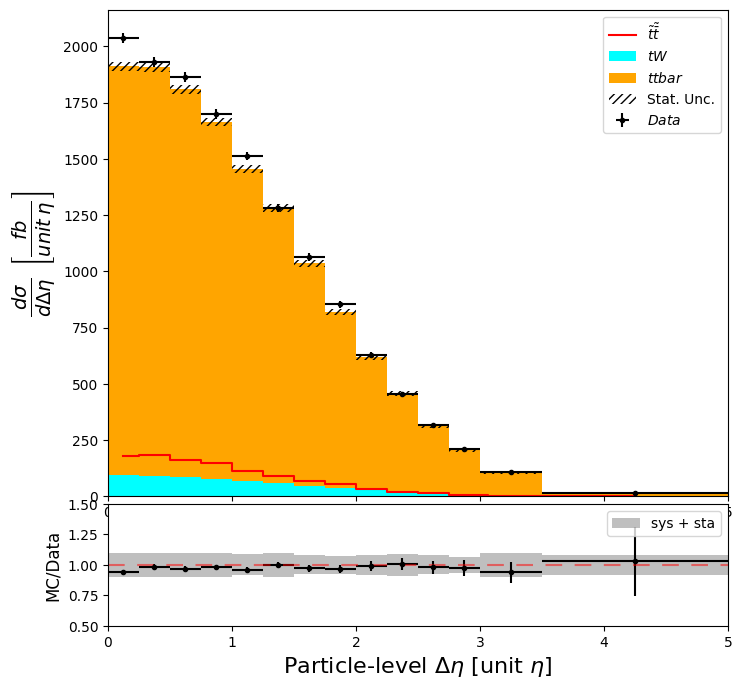

In [ ]:
cross_last('deta',0,0)

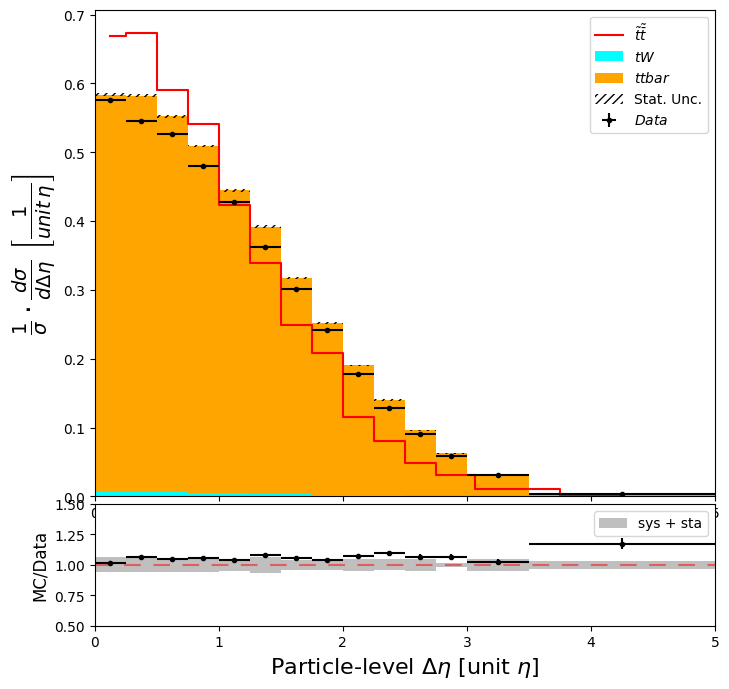

In [ ]:
cross_last('deta',1,0)

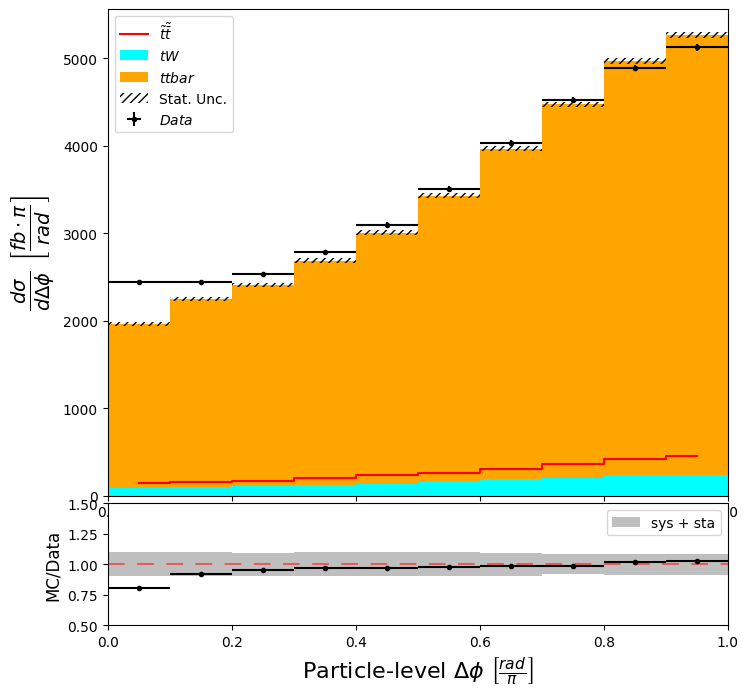

In [ ]:
cross_last('dphi',0,0)

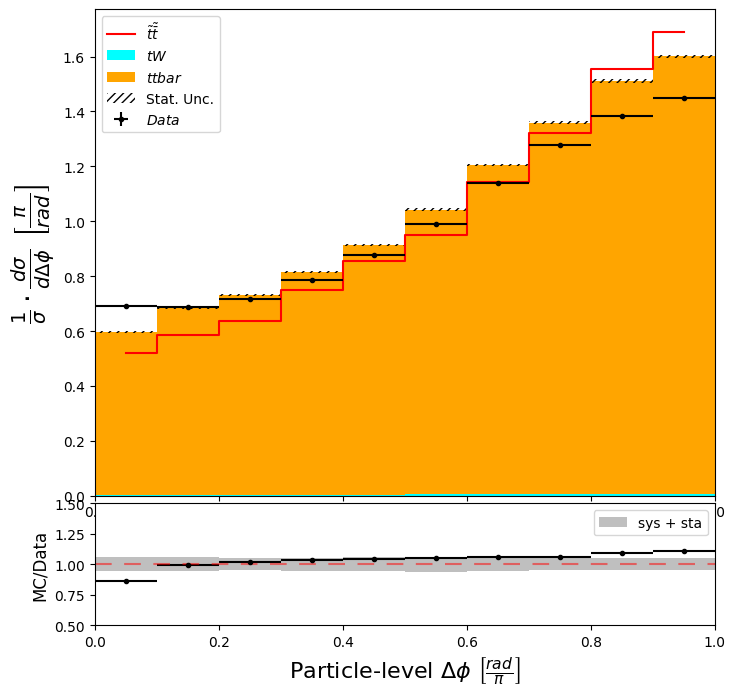

In [ ]:
cross_last('dphi',1,0)